## Import all Libraries

In [4]:
# AWS Rekognition to get bbox
import numpy as np
import boto3
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
from matplotlib import pyplot as plt
from utils.rekognition import determine_color, draw_animal_count
import cv2
import time
import math
import os
from utils.config import *
from utils.fix_annotation import *

In [5]:
#!export AWS_DEFAULT_REGION=us-east-1

## Get Bounding Boxes from Video Frames

In [9]:
#this is for the video
def draw_response(frame,response, animal_target):
    
    original_image = Image.fromarray(frame).copy()

    #draw the target count here first
    #image = draw_animal_count(response, animal_target, original_image)
    image = original_image
    # original image size
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    for customLabel in response['CustomLabels']:

        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
            
#           fnt = ImageFont.truetype('/usr/share/fonts/default/Type1/n019004l.pfb', 15)
            #print(customLabel['Name'])
            if customLabel['Name'] != 'Tag':
                label = customLabel['Name']
            else:
                pass 
        
#             text = label

#             text_width, text_height = fnt.getsize(label)
            color = determine_color(label, True)

#             button_width = int(text_width + 20)
#             button_height = int(text_height + 15)
#             button_size = (button_width, button_height)
#             button_img = Image.new('RGB', button_size, color)

#             button_draw = ImageDraw.Draw(button_img)
#             button_draw.text((10, 10), text, fill ='#000000', font=fnt)

#             image.paste(button_img, (int(left), int(top)))    

            points = (
                (left, top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            
            thickness = 5
            
            if label == 'cow':
                thickness = 7
                
            draw.line(points, fill=color, width=thickness)
    
    img = np.asarray(image)[:,:,::-1].copy()

    return img

In [10]:
def analyzeVideo(src_file, output_file, projectVersionArn, fps=5, min_confidence=75):
    
    start = time.time()
    
    rekognition = boto3.client('rekognition')        
    cap = cv2.VideoCapture(src_file)
    frameRate = cap.get(fps) #frame rate
    
    #function to write a video
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    
    imgSize = (int(width), int(height))
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    #writer = cv2.VideoWriter(output_file, fourcc, frameRate, imgSize, True)
    
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        

        ret, frame = cap.read()
       
        if (ret != True):
            break
            
        else:
            #inference on the extracted frame
            hasFrame, imageBytes = cv2.imencode(".jpg", frame)

            if(hasFrame):
                response = rekognition.detect_custom_labels(
                    Image={
                        'Bytes': imageBytes.tobytes(),
                    },
                    MinConfidence=min_confidence,
                    ProjectVersionArn = projectVersionArn
                )
                

            inferred_frame = draw_response(frame, response, animal_target='cow')
            inferred_frame = cv2.cvtColor(inferred_frame, cv2.COLOR_BGR2RGB)
            if frameId % 50 == 0:
                print("Finish Processing {} frame".format(frameId))
                plt.imshow(inferred_frame)
                plt.title("Frame {}".format(int(frameId)))
                plt.show()
            #writer.write(inferred_frame)

    cap.release()
    #writer.release()
    cv2.destroyAllWindows()
    
    end = time.time()
    print('total time lapse', end - start)


Finish Processing 0.0 frame


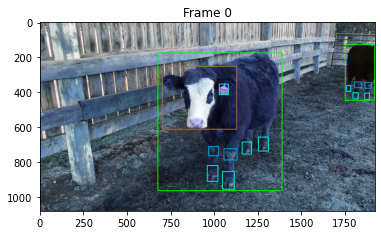

Finish Processing 50.0 frame


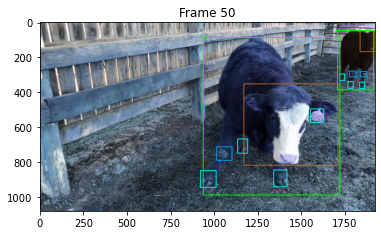

Finish Processing 100.0 frame


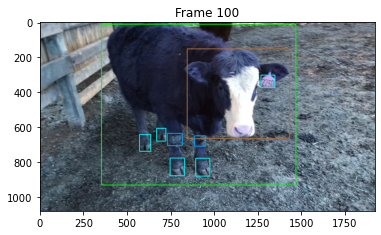

Finish Processing 150.0 frame


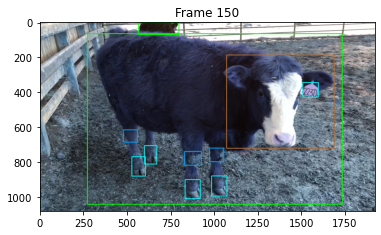

Finish Processing 200.0 frame


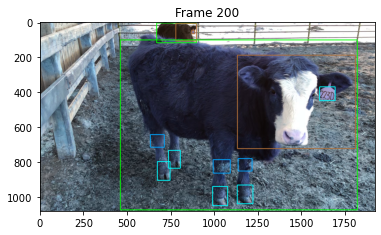

Finish Processing 250.0 frame


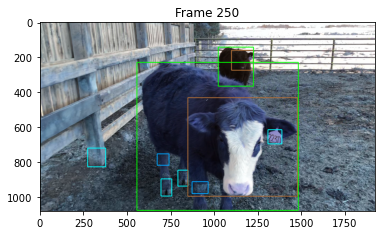

Finish Processing 300.0 frame


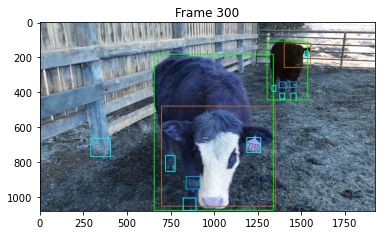

UnboundLocalError: local variable 'label' referenced before assignment

In [11]:
six_class_arn = 'arn:aws:rekognition:us-east-1:617989056061:project/cow-detector/version/cow-detector.2021-05-11T13.23.57/1620764637425'
src_video = 'data/demo_videos/cattle_single_2.mov'
output_video = 'bbox_out.mp4'

analyzeVideo(src_video, output_video, six_class_arn)
print('finished analyzing the video')

In [ ]:
%%HTML
<video width="400" height="320" controls>
  <source src="bbox_out.mp4" type="video/mp4">
</video